In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [50]:
# Import OpenSense modules as submodules
import sys
import os

sys.path.append(os.path.abspath("./pycomlink/"))
sys.path.append(os.path.abspath("./poligrain/src/"))
sys.path.append(os.path.abspath("./mergeplg/src/"))

import pycomlink as pycml 
import poligrain as plg

# OpenMRG analysis
OPEN FILES

In [51]:
dataset = 'OpenMRG'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc')     
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")          
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc").R_acc                              

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'rainfall_radar'})  
ds_rad['rainfall_add_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_add_IDW.nc').rainfall_add_IDW
ds_rad['rainfall_add_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_pBK.nc').rainfall_add_pBK
ds_rad['rainfall_add_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_lBK.nc').rainfall_add_lBK
ds_rad['rainfall_mul_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_IDW.nc').rainfall_mul_IDW
ds_rad['rainfall_mul_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_pBK.nc').rainfall_mul_pBK
ds_rad['rainfall_mul_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_lBK.nc').rainfall_mul_lBK
ds_rad['rainfall_ked']=xr.open_dataset(adj_path+dataset+'_rainfall_ked.nc').rainfall_ked

COMPARE RADAR AND RAIN GAUGES

In [52]:
# fields = [[gauge name, radar name]]
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK',
          'rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

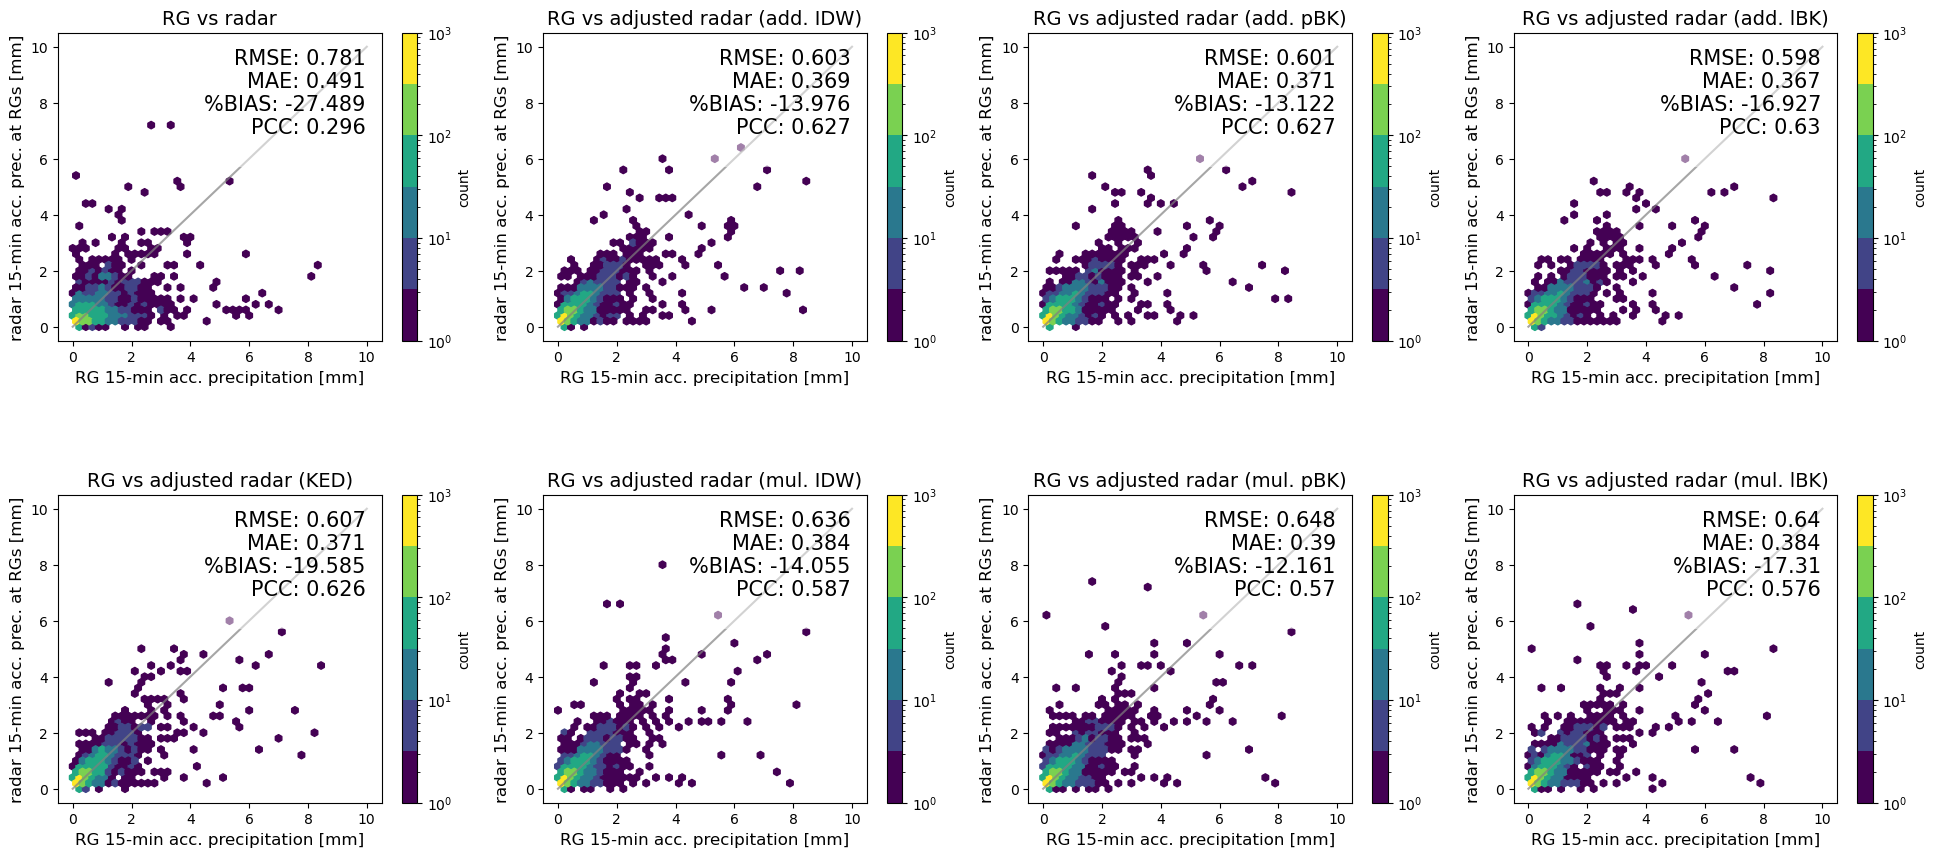

In [53]:
# fields = [[gauge name, title]]
fields = [['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK'],
          ['rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']]
titles = [['RG vs radar', 'RG vs adjusted radar (add. IDW)', 'RG vs adjusted radar (add. pBK)', 'RG vs adjusted radar (add. lBK)'],
          ['RG vs adjusted radar (KED)', 'RG vs adjusted radar (mul. IDW)', 'RG vs adjusted radar (mul. pBK)', 'RG vs adjusted radar (mul. lBK)']]

threshold = 0.2

fig, ax = plt.subplots(2, len(fields[0]), figsize=(6*len(fields[0]), 10)) 

for i in range(0,2):
    for j in range(0,4):

        hx = plg.validation.plot_hexbin(
            ds_gauges.rainfall_amount.values.flatten(),
            ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=0.1,
            est_thresh=0.1,
            ax=ax[i, j],
        )

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_gauges.rainfall_amount.values.flatten(),
            estimate=ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold)])

        ax[i, j].text(
            0.95, 0.95,                 
            "RMSE: "+str(round(metric.root_mean_square_error.values[0], 3))+'\n'+
            "MAE: "+str(round(metric.mean_absolute_error.values[0], 3))+'\n'+
            "%BIAS: "+str(round(metric.percent_bias.values[0], 3))+'\n'+
            "PCC: "+str(round(metric.pearson_correlation_coefficient.values[0], 3))+'\n',             
            transform=ax[i, j].transAxes,     
            ha='right', va='top',       
            fontsize=15, color='black',  
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  
        )

        ax[i, j].set_ylabel('radar 15-min acc. prec. at RGs [mm]', fontsize=12)
        ax[i, j].set_xlabel('RG 15-min acc. precipitation [mm]', fontsize=12)
        ax[i, j].set_title(titles[i][j], fontsize=14)

plt.subplots_adjust(hspace=0.5)

INTENSITY ANALYSIS

In [54]:
# prec_classes [lower limit, upper limit, class name (int)]
prec_classes = np.array([[0.2,0.625, 1], [0.625, 2.5, 2], [2.5, 12.5, 3]])
threshold = 0.2
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK',
          'rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for item in prec_classes:
    data = xr.where((ds_gauges.rainfall_amount >= item[0])&(ds_gauges.rainfall_amount < item[1]), ds_gauges, np.nan) 
    for field in fields:
        if start == 0:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = metric
            start += 1
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = pd.concat([result, metric])

c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_metho

In [55]:
result

,ref_thresh,est_thresh,pearson_correlation_coefficient,coefficient_of_variation,root_mean_square_error,mean_absolute_error,percent_bias,reference_mean_rainfall,estimate_mean_rainfall,false_positive_mean_rainfall,false_negative_mean_rainfall,N_all,N_nan,N_nan_ref,N_nan_est,class,field,ndata
0,0.2,0.2,0.193080,1.184546,0.393505,0.278172,-25.229995,0.324911,0.242936,0.454160,0.419601,97152,94631,94631,94631,1.0,rainfall_radar,2521
0,0.2,0.2,0.390101,0.860785,0.280104,0.219555,-7.257076,0.324254,0.300723,0.369825,0.425208,97152,94637,94631,94637,1.0,rainfall_add_IDW,2521
0,0.2,0.2,0.390044,0.873456,0.283872,0.221235,-5.919244,0.324254,0.305061,0.377124,0.427195,97152,94637,94631,94637,1.0,rainfall_add_pBK,2521
0,0.2,0.2,0.389542,0.850180,0.277828,0.217364,-10.645848,0.324254,0.289735,0.369624,0.423514,97152,94637,94631,94637,1.0,rainfall_add_lBK,2521
0,0.2,0.2,0.388459,0.828114,0.272050,0.218946,-13.473467,0.324254,0.280566,0.366296,0.422532,97152,94637,94631,94637,1.0,rainfall_ked,2521
0,0.2,0.2,0.375700,0.919534,0.298999,0.226372,-6.889406,0.324254,0.301915,0.372276,0.425197,97152,94637,94631,94637,1.0,rainfall_mul_IDW,2521
0,0.2,0.2,0.364923,0.975549,0.316576,0.230531,-3.882232,0.324254,0.311666,0.380078,0.425876,97152,94637,94631,94637,1.0,rainfall_mul_pBK,2521
0,0.2,0.2,0.372212,0.924589,0.301468,0.224001,-9.759575,0.324254,0.292609,0.369627,0.424485,97152,94637,94631,94637,1.0,rainfall_mul_lBK,2521
0,0.2,0.2,0.199024,0.608037,0.924405,0.773140,-50.758820,1.167093,0.574690,NaN,1.134332,97152,95979,95979,95979,2.0,rainfall_radar,1173
0,0.2,0.2,0.366222,0.586440,0.761105,0.570142,-28.313684,1.168750,0.837834,NaN,1.159247,97152,95984,95979,95984,2.0,rainfall_add_IDW,1173


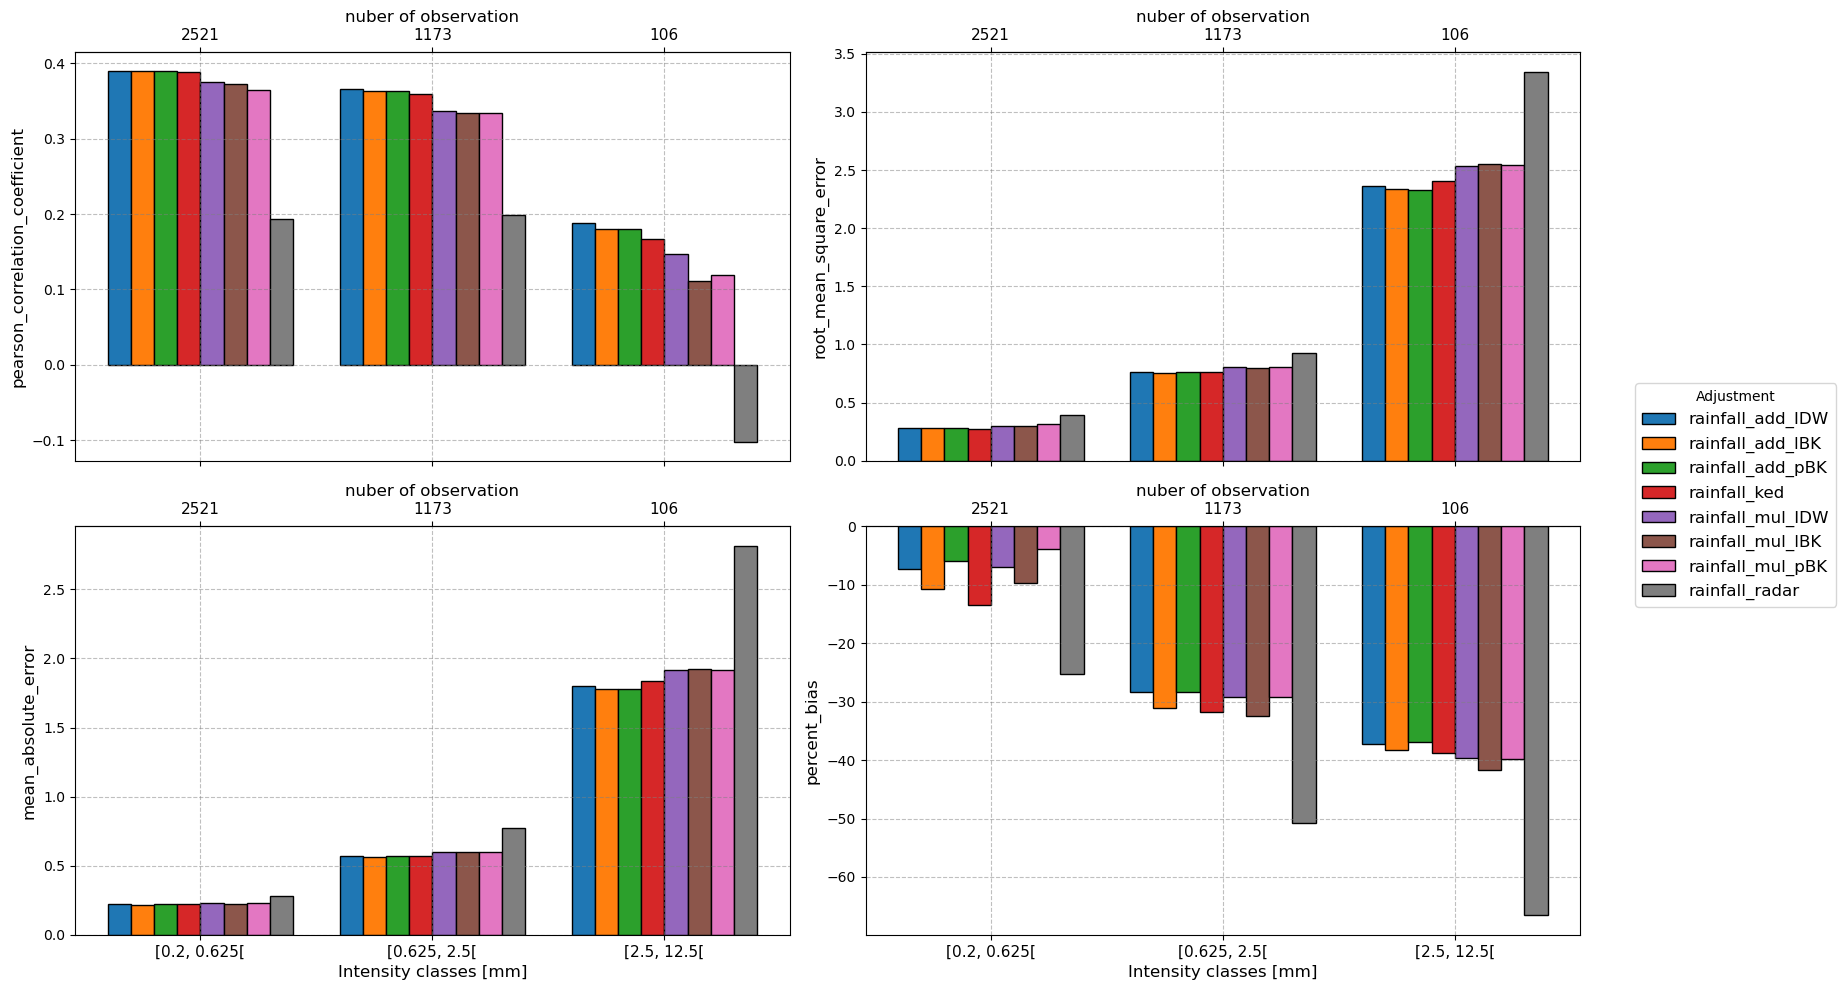

In [ ]:
metrics = [
    'pearson_correlation_coefficient',
    'root_mean_square_error',
    'mean_absolute_error',
    'percent_bias'
]

df_sorted = result.sort_values(['class', 'field'])
classes = df_sorted['class'].unique()
fields = df_sorted['field'].unique()
n_obs = df_sorted['ndata'].unique()

matrici = {}
for score_col in metrics:
    matrix = []
    for c in classes:
        vals = []
        for f in fields:
            val = df_sorted.loc[
                (df_sorted['class'] == c) & (df_sorted['field'] == f), score_col
            ]
            vals.append(val.iloc[0] if not val.empty else np.nan)
        matrix.append(vals)
    matrici[score_col] = np.array(matrix)

x = np.arange(len(classes))
width = 0.8 / len(fields)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for ax, score_col in zip(axes, metrics):
    for i, f in enumerate(fields):
        ax.bar(
            x + i * width,
            matrici[score_col][:, i],
            width,
            label=f if ax == axes[0] else "",
            edgecolor='black'
        )
    ax.set_ylabel(score_col, fontsize=12)
    ax.set_xticks(x + width * (len(fields) - 1) / 2)
    ax.set_xticklabels(
        ['[0.2, 0.625[', '[0.625, 2.5[', '[2.5, 12.5['], fontsize=11
    )
    ax.grid(linestyle='--', color='gray', alpha=0.5)

    secax = ax.secondary_xaxis('top')
    secax.set_xticks(x + width * (len(fields) - 1) / 2)
    secax.set_xticklabels([n for n in n_obs], fontsize=11)
    secax.set_xlabel('nuber of observation', fontsize=12)

axes[2].set_xlabel('Intensity classes [mm]', fontsize=12)
axes[3].set_xlabel('Intensity classes [mm]', fontsize=12)

fig.legend(
    fields,
    title='Adjustment',
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## OpenRainER analysis
OPEN FILES

In [57]:
dataset = 'OpenRainER'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/covi_2024_OpenRainER/AWS_rainfall.nc')        
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")       
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc").R_acc             

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'rainfall_radar'})  
ds_rad['rainfall_add_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_add_IDW.nc').rainfall_add_IDW
ds_rad['rainfall_add_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_pBK.nc').rainfall_add_pBK
ds_rad['rainfall_add_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_lBK.nc').rainfall_add_lBK
ds_rad['rainfall_mul_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_IDW.nc').rainfall_mul_IDW
ds_rad['rainfall_mul_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_pBK.nc').rainfall_mul_pBK
ds_rad['rainfall_mul_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_lBK.nc').rainfall_mul_lBK
ds_rad['rainfall_ked']=xr.open_dataset(adj_path+dataset+'_rainfall_ked.nc').rainfall_ked

In [58]:
# fields = [[gauge name, radar name]]
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK',
          'rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

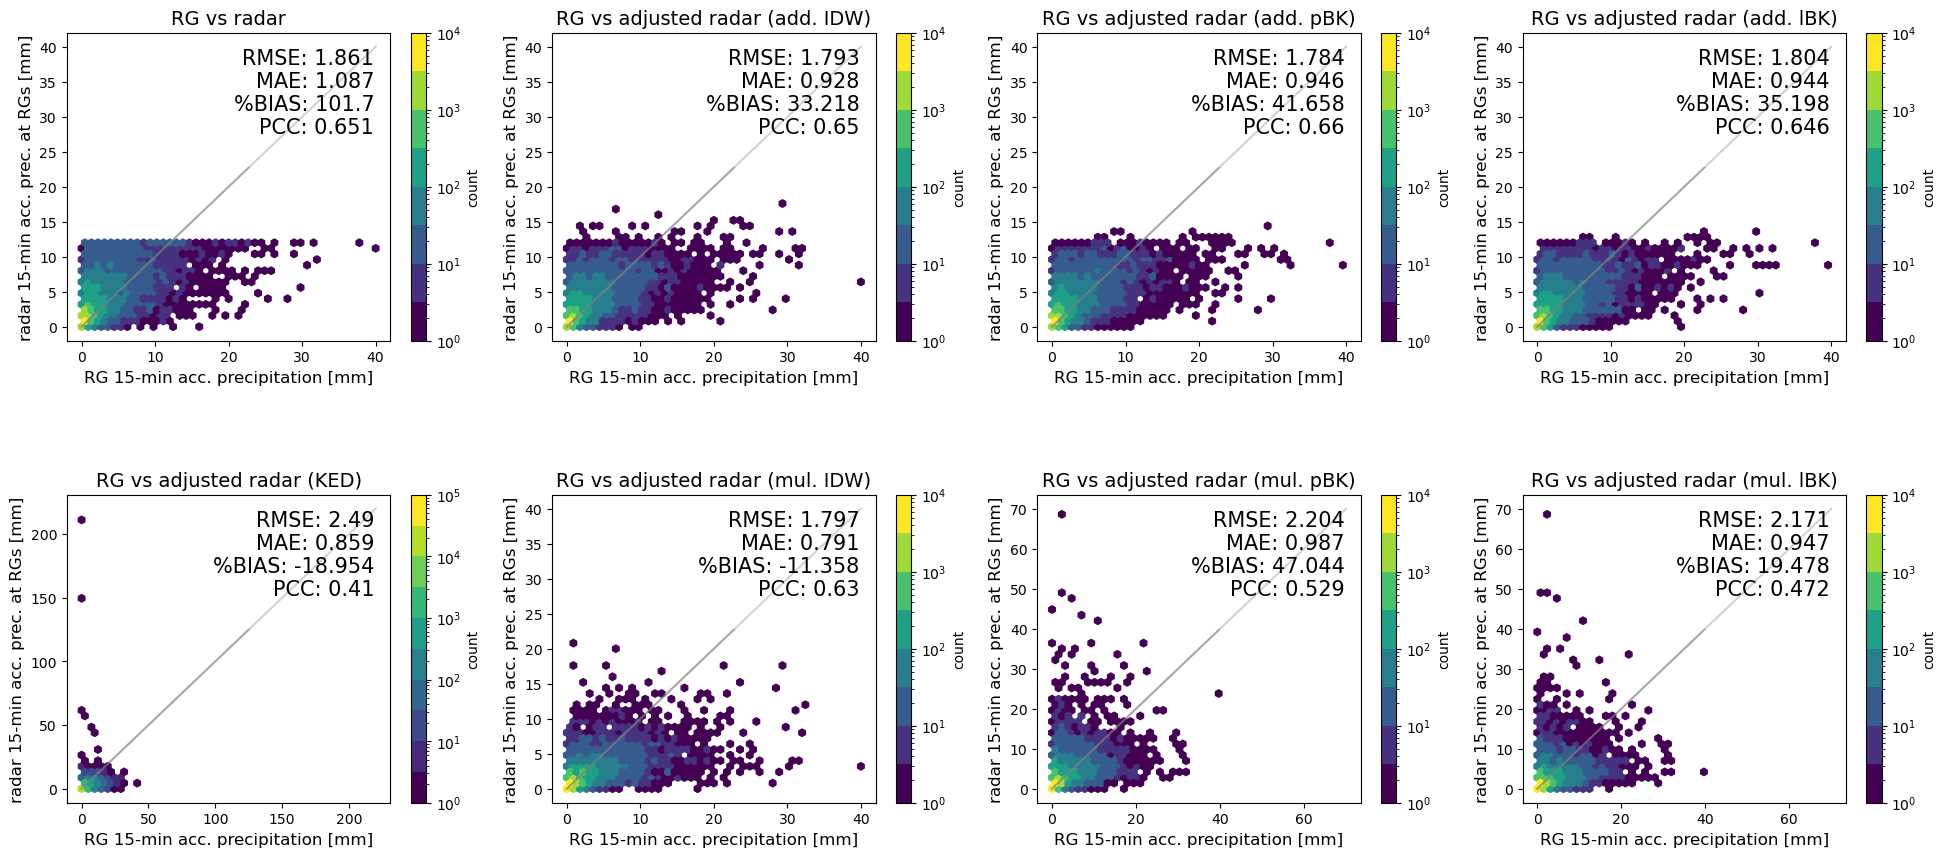

In [59]:
# fields = [[gauge name, title]]
fields = [['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK'],
          ['rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']]
titles = [['RG vs radar', 'RG vs adjusted radar (add. IDW)', 'RG vs adjusted radar (add. pBK)', 'RG vs adjusted radar (add. lBK)'],
          ['RG vs adjusted radar (KED)', 'RG vs adjusted radar (mul. IDW)', 'RG vs adjusted radar (mul. pBK)', 'RG vs adjusted radar (mul. lBK)']]

threshold = 0.2

fig, ax = plt.subplots(2, len(fields[0]), figsize=(6*len(fields[0]), 10)) 

for i in range(0,2):
    for j in range(0,4):

        hx = plg.validation.plot_hexbin(
            ds_gauges.rainfall_amount.values.flatten(),
            ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=0.1,
            est_thresh=0.1,
            ax=ax[i, j],
        )

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_gauges.rainfall_amount.values.flatten(),
            estimate=ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold)])

        ax[i, j].text(
            0.95, 0.95,                 
            "RMSE: "+str(round(metric.root_mean_square_error.values[0], 3))+'\n'+
            "MAE: "+str(round(metric.mean_absolute_error.values[0], 3))+'\n'+
            "%BIAS: "+str(round(metric.percent_bias.values[0], 3))+'\n'+
            "PCC: "+str(round(metric.pearson_correlation_coefficient.values[0], 3))+'\n',             
            transform=ax[i, j].transAxes,     
            ha='right', va='top',       
            fontsize=15, color='black',  
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  
        )

        ax[i, j].set_ylabel('radar 15-min acc. prec. at RGs [mm]', fontsize=12)
        ax[i, j].set_xlabel('RG 15-min acc. precipitation [mm]', fontsize=12)
        ax[i, j].set_title(titles[i][j], fontsize=14)

plt.subplots_adjust(hspace=0.5)

DISTANCE ANALYSIS

In [60]:
distances = np.arange(2000, 32000, 2000) # [m]
n_gauges = np.array([])
threshold = 0.2

fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK',
          'rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for max_distance in distances:
    closest_neigbors = plg.spatial.get_closest_points_to_line(
        ds_cmls, ds_gauges.rainfall_amount, max_distance=max_distance, n_closest=len(ds_gauges.id.values)
    )

    closest_rgs = closest_neigbors.neighbor_id.values.flatten()
    ds_closegauges = ds_gauges.sel(id=np.unique(closest_rgs[closest_rgs!= None]))
    n_gauges = np.concat([n_gauges, np.array([len(ds_closegauges.id.values)])])

    for field in fields:

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_closegauges.rainfall_amount.values.flatten(),
            estimate=ds_closegauges[field].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold,
        )])
        metric['distance'] = [max_distance]
        metric['field'] = [field]

        if start == 0:
            result_metric = metric
            start += 1
        else:
            result_metric = pd.concat([result_metric, metric])

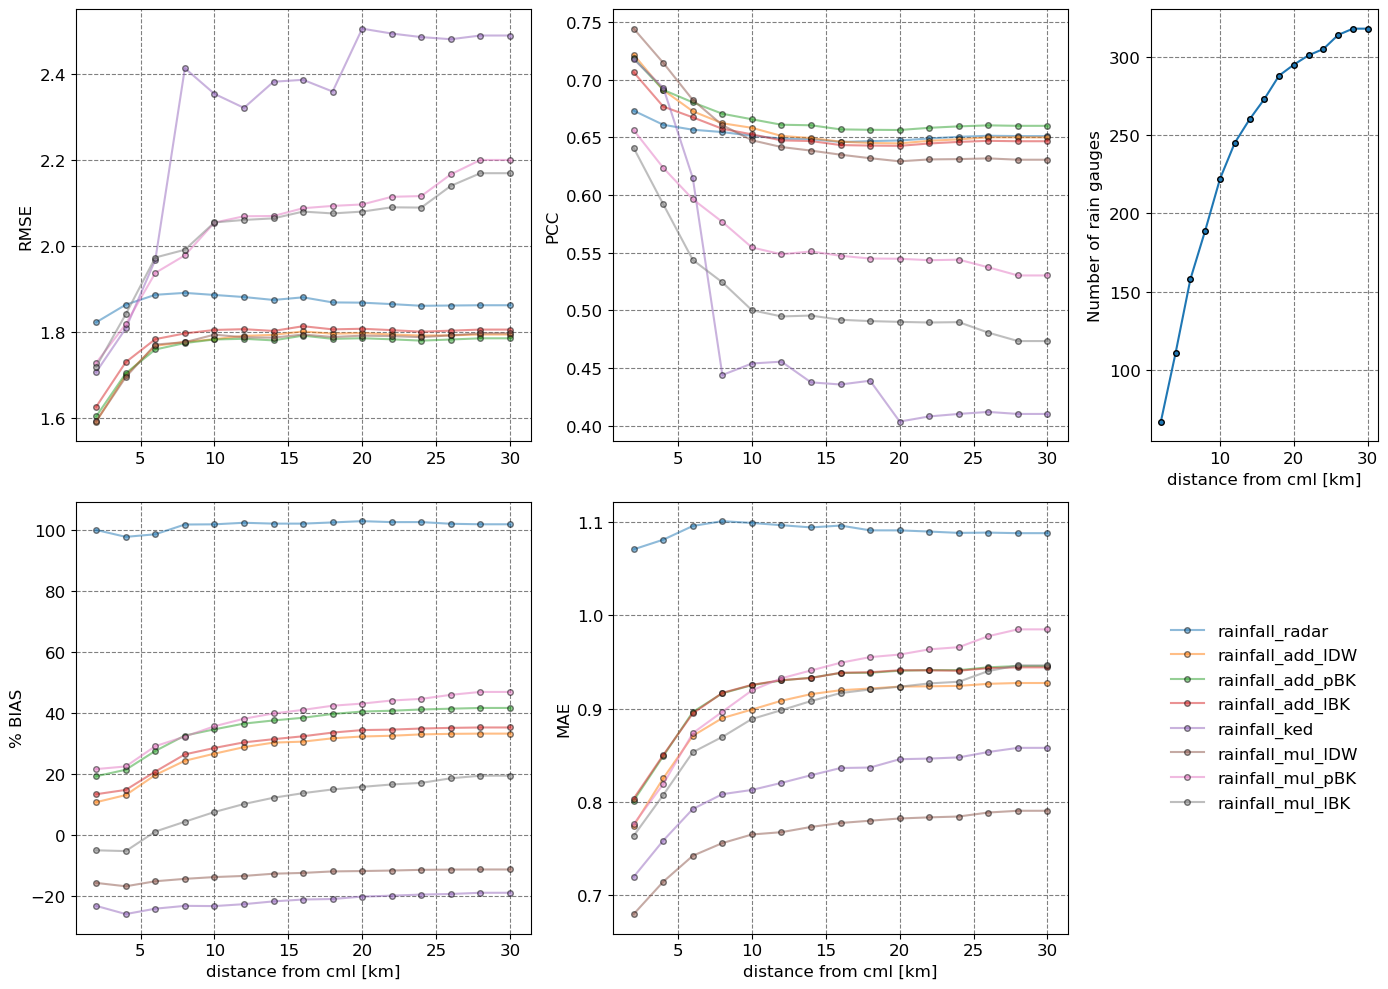

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK',
          'rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.5])

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
legend_ax = fig.add_subplot(gs[1, 2])
legend_ax.axis('off')  

handles = []

# --- RMSE ---
for field in fields:
    result = result_metric[result_metric.field == field]
    line, = ax00.plot(result.distance/1000, result.root_mean_square_error,
                      marker='o', markeredgecolor='black', label=field, alpha=0.5, markersize=4)
    handles.append(line)

ax00.set_ylabel('RMSE', fontsize=12)
ax00.tick_params(axis='both', labelsize=12)
ax00.grid(linestyle='--', color='gray')

# --- PCC ---
for field in fields:
    result = result_metric[result_metric.field == field]
    ax01.plot(result.distance/1000, result.pearson_correlation_coefficient,
              marker='o', markeredgecolor='black', alpha=0.5, markersize=4)

ax01.set_ylabel('PCC', fontsize=12)
ax01.tick_params(axis='both', labelsize=12)
ax01.grid(linestyle='--', color='gray')

# --- Number of rain gauges ---
ax02.plot(distances/1000, n_gauges, marker='o', markersize=4, markeredgecolor='black')
ax02.set_xlabel('distance from cml [km]', fontsize=12)
ax02.set_ylabel('Number of rain gauges', fontsize=12)
ax02.tick_params(axis='both', labelsize=12)
ax02.grid(linestyle='--', color='gray')

# --- %BIAS ---
for field in fields:
    result = result_metric[result_metric.field == field]
    ax10.plot(result.distance/1000, result.percent_bias,
              marker='o', markeredgecolor='black', alpha=0.5, markersize=4)

ax10.set_xlabel('distance from cml [km]', fontsize=12)
ax10.set_ylabel('% BIAS', fontsize=12)
ax10.tick_params(axis='both', labelsize=12)
ax10.grid(linestyle='--', color='gray')

# --- MAE ---
for field in fields:
    result = result_metric[result_metric.field == field]
    ax11.plot(result.distance/1000, result.mean_absolute_error,
              marker='o', markeredgecolor='black', alpha=0.5, markersize=4)

ax11.set_xlabel('distance from cml [km]', fontsize=12)
ax11.set_ylabel('MAE', fontsize=12)
ax11.tick_params(axis='both', labelsize=12)
ax11.grid(linestyle='--', color='gray')


plt.tight_layout()

legend_ax.legend(handles, fields, loc='center', frameon=False, ncol=1, fontsize=12)

INTENSITY ANALYSIS

In [62]:
# prec_classes [lower limit, upper limit, class name (int)]
prec_classes = np.array([[0.2,0.625, 1], [0.625, 2.5, 2], [2.5, 12.5, 3], [12.5, 100, 4]])
threshold = 0.2
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 'rainfall_add_lBK',
          'rainfall_ked', 'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for item in prec_classes:
    data = xr.where((ds_gauges.rainfall_amount >= item[0])&(ds_gauges.rainfall_amount < item[1]), ds_gauges, np.nan) 
    for field in fields:
        if start == 0:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = metric
            start += 1
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = pd.concat([result, metric])

c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:1

In [63]:
result

,ref_thresh,est_thresh,pearson_correlation_coefficient,coefficient_of_variation,root_mean_square_error,mean_absolute_error,percent_bias,reference_mean_rainfall,estimate_mean_rainfall,false_positive_mean_rainfall,false_negative_mean_rainfall,N_all,N_nan,N_nan_ref,N_nan_est,class,field,ndata
0,0.2,0.2,0.361481,3.847083,1.353297,0.834582,236.617022,0.299634,1.008619,NaN,0.226897,2817408,2798837,2798837,2798837,1.0,rainfall_radar,18571
0,0.2,0.2,0.276472,3.038222,0.942997,0.497807,82.088992,0.299634,0.545600,NaN,0.251497,2817408,2798837,2798837,2798837,1.0,rainfall_add_IDW,18571
0,0.2,0.2,0.303008,3.141619,0.984611,0.528499,96.350552,0.299634,0.588333,NaN,0.247283,2817408,2798837,2798837,2798837,1.0,rainfall_add_pBK,18571
0,0.2,0.2,0.292317,3.104097,0.965855,0.513378,86.902747,0.299634,0.560024,NaN,0.249433,2817408,2798837,2798837,2798837,1.0,rainfall_add_lBK,18571
0,0.2,0.2,0.092231,6.699629,2.008168,0.343323,18.094674,0.299634,0.353852,NaN,0.248713,2817408,2798837,2798837,2798837,1.0,rainfall_ked,18571
0,0.2,0.2,0.309025,1.961716,0.596289,0.332077,33.467075,0.299634,0.399913,NaN,0.238852,2817408,2798837,2798837,2798837,1.0,rainfall_mul_IDW,18571
0,0.2,0.2,0.241433,4.014692,1.266329,0.567592,132.040341,0.299634,0.695271,NaN,0.233464,2817408,2798837,2798837,2798837,1.0,rainfall_mul_pBK,18571
0,0.2,0.2,0.210883,3.887457,1.197736,0.489940,93.077362,0.299634,0.578525,NaN,0.239922,2817408,2798837,2798837,2798837,1.0,rainfall_mul_lBK,18571
0,0.2,0.2,0.267237,1.600980,2.578915,1.773669,118.856288,1.293373,2.830628,NaN,1.187940,2817408,2810663,2810663,2810663,2.0,rainfall_radar,6745
0,0.2,0.2,0.283279,1.439867,1.979610,1.264452,51.909089,1.293373,1.964751,NaN,1.187966,2817408,2810663,2810663,2810663,2.0,rainfall_add_IDW,6745


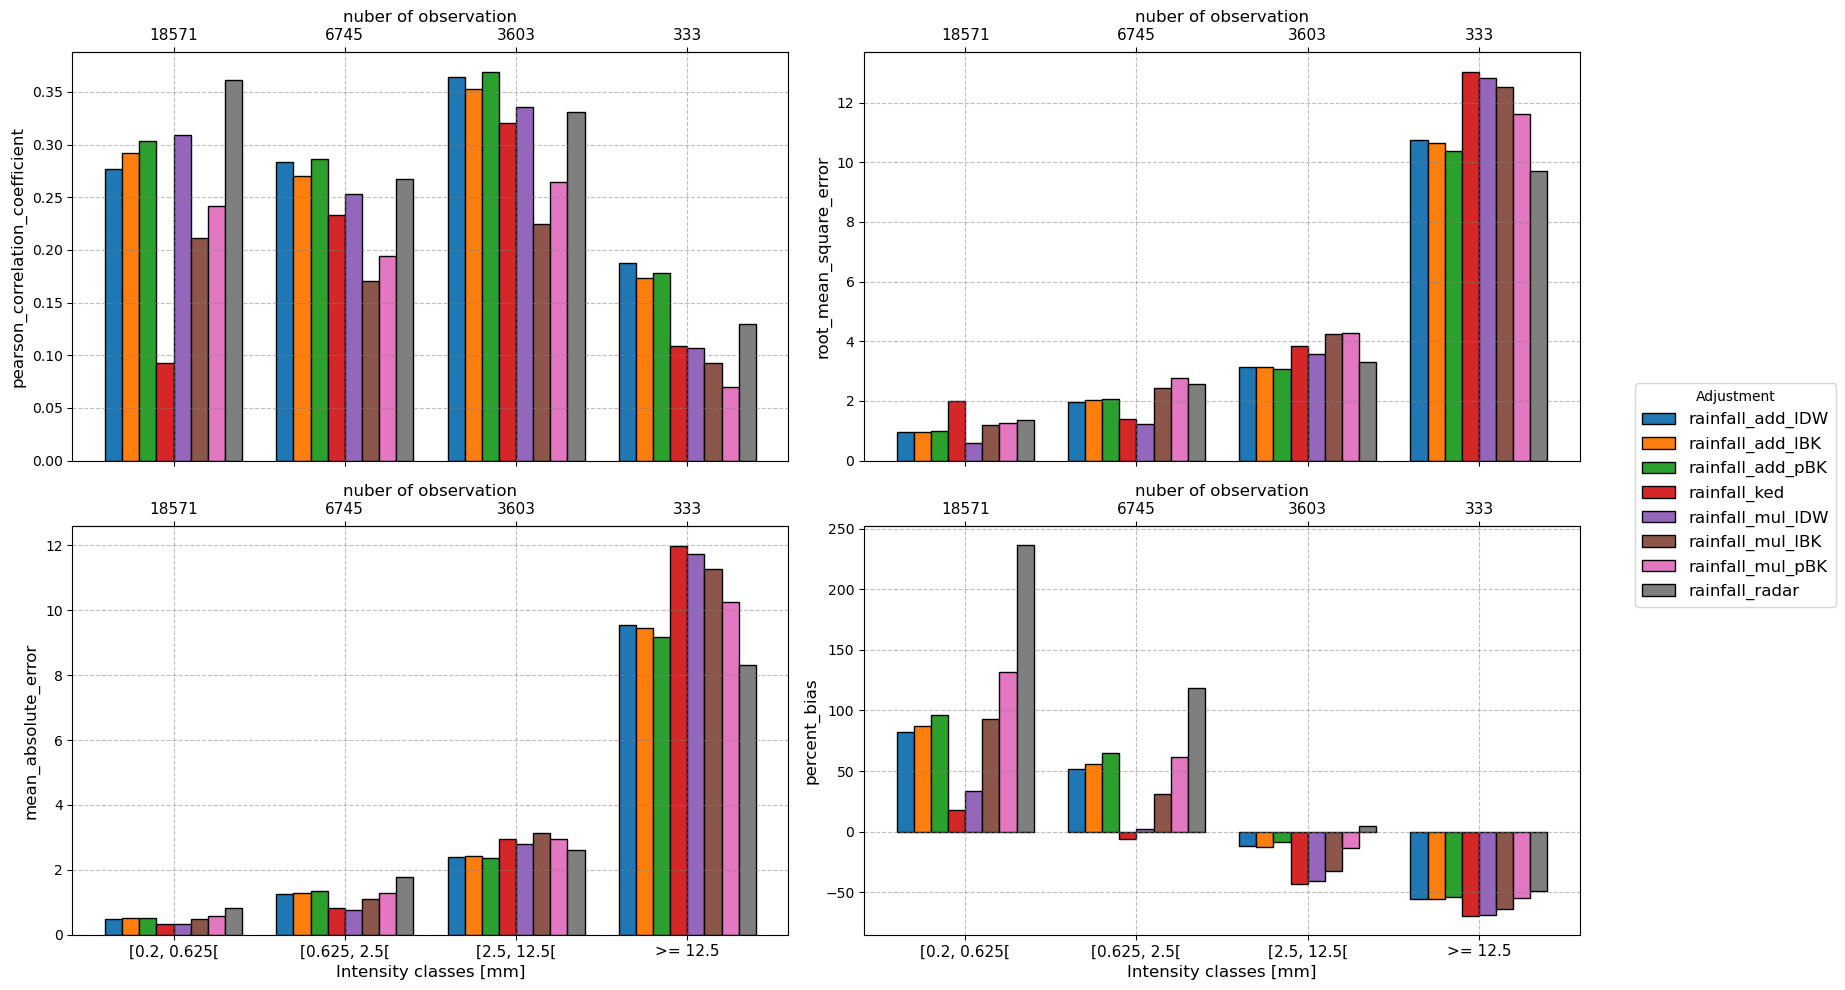

In [ ]:
metrics = [
    'pearson_correlation_coefficient',
    'root_mean_square_error',
    'mean_absolute_error',
    'percent_bias'
]

df_sorted = result.sort_values(['class', 'field'])
classes = df_sorted['class'].unique()
fields = df_sorted['field'].unique()
n_obs = df_sorted['ndata'].unique()

matrici = {}
for score_col in metrics:
    matrix = []
    for c in classes:
        vals = []
        for f in fields:
            val = df_sorted.loc[
                (df_sorted['class'] == c) & (df_sorted['field'] == f), score_col
            ]
            vals.append(val.iloc[0] if not val.empty else np.nan)
        matrix.append(vals)
    matrici[score_col] = np.array(matrix)

x = np.arange(len(classes))
width = 0.8 / len(fields)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for ax, score_col in zip(axes, metrics):
    for i, f in enumerate(fields):
        ax.bar(
            x + i * width,
            matrici[score_col][:, i],
            width,
            label=f if ax == axes[0] else "",
            edgecolor='black'
        )
    ax.set_ylabel(score_col, fontsize=12)
    ax.set_xticks(x + width * (len(fields) - 1) / 2)
    ax.set_xticklabels(
        ['[0.2, 0.625[', '[0.625, 2.5[', '[2.5, 12.5[', '>= 12.5'], fontsize=11
    )
    ax.grid(linestyle='--', color='gray', alpha=0.5)

    secax = ax.secondary_xaxis('top')
    secax.set_xticks(x + width * (len(fields) - 1) / 2)
    secax.set_xticklabels([n for n in n_obs], fontsize=11)
    secax.set_xlabel('nuber of observation', fontsize=12)

axes[2].set_xlabel('Intensity classes [mm]', fontsize=12)
axes[3].set_xlabel('Intensity classes [mm]', fontsize=12)

fig.legend(
    fields,
    title='Adjustment',
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()